In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

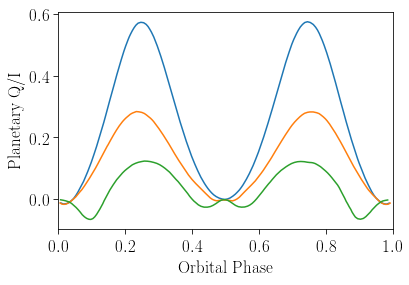

In [2]:
with open('/home/taylor/Downloads/wpd_datasets.csv') as file:
    lines = file.readlines()

lines = [line.strip() for line in lines]
lines = [line.split(',') for line in lines]
lines = lines[2:]

x1, y1 = np.array(lines)[:,:2].astype(float).T
endline = np.where(np.array(lines)[:,2]=='')[0][0]
x2, y2 = np.array(lines)[:endline,2:4].astype(float).T
endline = np.where(np.array(lines)[:,4]=='')[0][0]
x3, y3 = np.array(lines)[:endline,4:].astype(float).T

x1 = (x1-0.25)%1
x2 = (x2-0.25)%1
x3 = (x3-0.25)%1

order = np.argsort(x1)
x1 = x1[order]
y1 = y1[order]

order = np.argsort(x2)
x2 = x2[order]
y2 = y2[order]

order = np.argsort(x3)
x3 = x3[order]
y3 = y3[order]

x1s = convolve(x1, Box1DKernel(3))[1:-1]
y1s = convolve(y1, Box1DKernel(3))[1:-1]

x2s = convolve(x2, Box1DKernel(3))[1:-1]
y2s = convolve(y2, Box1DKernel(3))[1:-1]

x3s = convolve(x3, Box1DKernel(3))[1:-1]
y3s = convolve(y3, Box1DKernel(3))[1:-1]

plt.plot(x1s, y1s)
plt.plot(x2s, y2s)
plt.plot(x3s, y3s)

plt.xlim(0,1)
plt.xlabel(r'$\rm Orbital~Phase$')
plt.ylabel(r'$\rm Planetary~Q/I$')

plt.show()

In [3]:
systems = eppe.Systems(load=True, polEff=0.6, randomOrientation=False, albedo=0.3)

systems.catalogue['inc'] *= 0
systems.catalogue['inc'] += 90

In [4]:
i = systems.name_to_index('tau Boo b')

In [5]:
for key in systems.catalogue.keys():
    systems.catalogue[key] = np.repeat(np.array([systems.catalogue[key][i]]), 3)

In [7]:
expTime = np.pi/3
intTime = 365*24.

randomOrientation = False
albedo = 0.3#'theo'
filt = 'V'
pNoiseMultiplier = 1.8
stellarVariability = False

savePlots = False
savepath = 'saves/'

mission = eppe.mission(systems, filt=filt, trans=0.9, pNoiseMultiplier=1.8, usePhoenix=True) # EPPE
fplanets, fstars, times, phases = mission.observe_photometric(expTime, intTime, photonNoise=True, pStart=0)

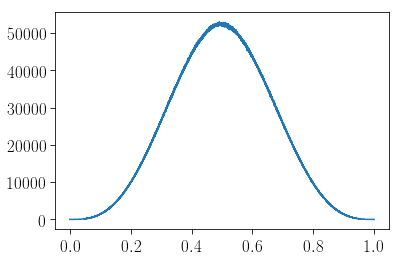

In [8]:
i = 0

order = np.argsort(phases[i])
phases = phases[i][order]
lambertCurve = fplanets[i][order]

plt.plot(phases, lambertCurve)
plt.show()

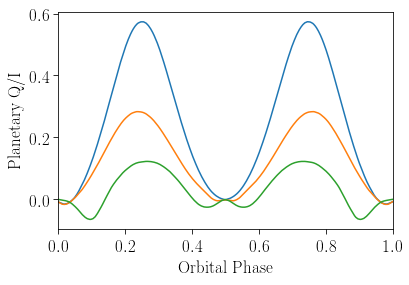

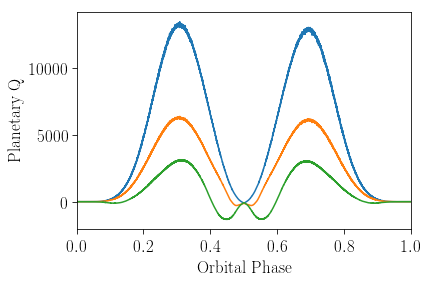

In [9]:
y_interps = []

for xtmp,ytmp in [[x1s-0.5,y1s], [x2s-0.5,y2s], [x3s-0.5,y3s]]:
    xv1 = np.abs(xtmp[xtmp<0])
    xv2 = xtmp[xtmp>0]
    yv1 = ytmp[xtmp<0]
    yv2 = ytmp[xtmp>0]

    f1 = interp1d(xv1, yv1, fill_value='extrapolate')
    f2 = interp1d(xv2, yv2, fill_value='extrapolate')

    y_interps.append(np.mean(np.append(f1(np.abs(phases-0.5))[np.newaxis,:], f2(np.abs(phases-0.5))[np.newaxis,:], axis=0), axis=0))

y1_interp, y2_interp, y3_interp = y_interps





plt.plot(phases, y1_interp)
plt.plot(phases, y2_interp)
plt.plot(phases, y3_interp)

plt.xlim(0,1)
plt.xlabel(r'$\rm Orbital~Phase$')
plt.ylabel(r'$\rm Planetary~Q/I$')

plt.show()






plt.plot(phases, y1_interp*lambertCurve)
plt.plot(phases, y2_interp*lambertCurve)
plt.plot(phases, y3_interp*lambertCurve)

plt.xlim(0,1)
plt.xlabel(r'$\rm Orbital~Phase$')
plt.ylabel(r'$\rm Planetary~Q$')

plt.show()

In [10]:
stokesCurves = mission.observe_polarization(expTime, intTime, stellarVariability=stellarVariability, pStart=0)
stokesCurves_ideal = mission.observe_polarization(expTime, intTime, photonNoise=False, pStart=0)

In [11]:
stokesNoise = np.array([(stokesCurves[i][:4]-stokesCurves_ideal[i][:4]+stokesCurves_ideal[i][:4].min(axis=1).reshape(-1,1))[:,order] for i in range(3)])

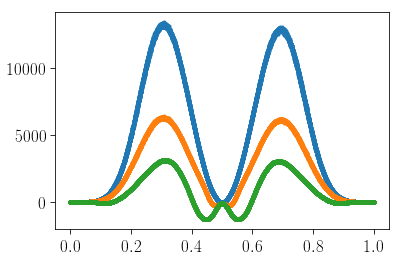

In [12]:
plt.plot(phases, y1_interp*lambertCurve, '.')
plt.plot(phases, y2_interp*lambertCurve, '.')
plt.plot(phases, y3_interp*lambertCurve, '.')
plt.show()

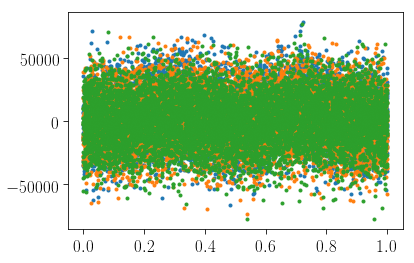

In [13]:
plt.plot(phases, stokesNoise[0][1]+y1_interp*lambertCurve, '.')
plt.plot(phases, stokesNoise[1][1]+y2_interp*lambertCurve, '.')
plt.plot(phases, stokesNoise[2][1]+y3_interp*lambertCurve, '.')
plt.show()

In [14]:
stokesCurve1 = np.copy(stokesNoise[0])
stokesCurve1[0] += lambertCurve
stokesCurve1[1] += y1_interp*lambertCurve
stokesCurve1 = np.append(stokesCurve1, times[i][order][np.newaxis,:], axis=0)
stokesCurve1 = np.append(stokesCurve1, phases[np.newaxis,:], axis=0)

stokesCurve2 = np.copy(stokesNoise[1])
stokesCurve2[0] += lambertCurve
stokesCurve2[1] += y2_interp*lambertCurve
stokesCurve2 = np.append(stokesCurve2, times[i][order][np.newaxis,:], axis=0)
stokesCurve2 = np.append(stokesCurve2, phases[np.newaxis,:], axis=0)

stokesCurve3 = np.copy(stokesNoise[2])
stokesCurve3[0] += lambertCurve
stokesCurve3[1] += y3_interp*lambertCurve
stokesCurve3 = np.append(stokesCurve3, times[i][order][np.newaxis,:], axis=0)
stokesCurve3 = np.append(stokesCurve3, phases[np.newaxis,:], axis=0)

In [15]:
q1_meas = (stokesCurve1[1])/(stokesCurve1[0])
q2_meas = (stokesCurve2[1])/(stokesCurve2[0])
q3_meas = (stokesCurve3[1])/(stokesCurve3[0])

q1 = y1_interp*lambertCurve/(stokesCurves_ideal[0][0])
q2 = y2_interp*lambertCurve/(stokesCurves_ideal[1][0])
q3 = y3_interp*lambertCurve/(stokesCurves_ideal[2][0])

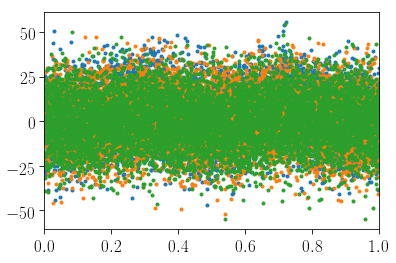

In [16]:
plt.plot(phases, 1e6*q1_meas, '.', c='C0')
plt.plot(phases, 1e6*q2_meas, '.', c='C1')
plt.plot(phases, 1e6*q3_meas, '.', c='C2')

# plt.plot(phases, 1e6*q1, '-', c='C0')
# plt.plot(phases, 1e6*q2, '-', c='C1')
# plt.plot(phases, 1e6*q3, '-', c='C2')

plt.xlim(0,1)

plt.show()

In [17]:
from scipy import stats

Planetary model atmosphere 1 contains only molecules, model 2 is similar to model 1, except for a tropospheric cloud layer, and model 3 is similar to model 2, except for a stratospheric haze layer.

#### Model 1 fitted with model 1

In [18]:
chisq1 = np.sum(((q1_meas-q1)/np.std(q1_meas-q1))**2)
chisq1

8365.518570022825

In [19]:
1 - stats.chi2.cdf(chisq1, len(q1))

0.4963444113348253

#### Model 2 fitted with model 2

In [20]:
chisq2 = np.sum(((q2_meas-q2)/np.std(q2_meas-q2))**2)
chisq2

8365.021644588885

In [21]:
1 - stats.chi2.cdf(chisq2, len(q1))

0.49787701348629987

#### Model 3 fitted with model 3

In [22]:
chisq3 = np.sum(((q3_meas-q3)/np.std(q3_meas-q3))**2)
chisq3

8365.038676825636

In [23]:
1 - stats.chi2.cdf(chisq3, len(q1))

0.4978244815329952

## This isn't really fair - I should fit the amplitude of the Rayleigh curve first

#### Model 2 fitted with model 1

In [24]:
chisq2_1 = np.sum(((q2_meas-q1)/np.std(q2_meas-q2))**2)
chisq2_1

8629.83098841214

In [25]:
1 - stats.chi2.cdf(chisq2_1, len(q1))

0.0211067453207755

#### Model 3 fitted with model 1

In [26]:
chisq3_1 = np.sum(((q3_meas-q1)/np.std(q3_meas-q3))**2)
chisq3_1

8955.847600473531

In [27]:
1 - stats.chi2.cdf(chisq3_1, len(q1))

3.9144027458304365e-06

## This is more fair - rescale Rayleigh curve first

In [28]:
chisq2_1 = np.sum(((q2_meas-q1/np.max(q1)*np.max(q2))/np.std(q2_meas-q2))**2)
chisq2_1

8363.590787132714

In [29]:
1 - stats.chi2.cdf(chisq2_1, len(q1))

0.50229045496957

In [30]:
chisq3_1 = np.sum(((q3_meas-q1/np.max(q1)*np.max(q3))/np.std(q3_meas-q3))**2)
chisq3_1

8371.46451996543

In [31]:
1 - stats.chi2.cdf(chisq3_1, len(q1))

0.47802138786159765

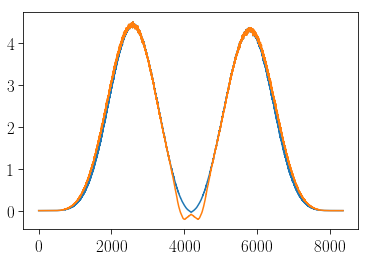

In [32]:
plt.plot(1e6*q1/np.max(q1)*np.max(q2))
plt.plot(1e6*q2)
plt.show()

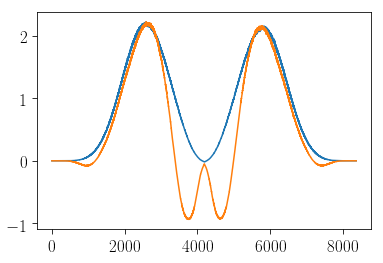

In [33]:
plt.plot(1e6*q1/np.max(q1)*np.max(q3))
plt.plot(1e6*q3)
plt.show()